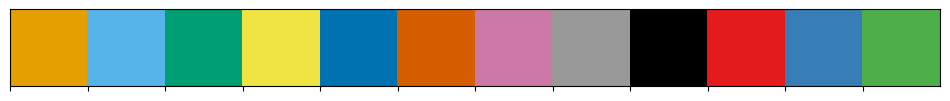

In [5]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import gym
from gym import spaces
import numpy as np
from Stochastic.src.environment.tree import Tree
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
colors = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]
sns.palplot(colors)
colors = sns.color_palette("hls", 12)

In [6]:
class NestedBanditEnv(gym.Env):
    """
    Nested Bandit environment where each arm is a full path from root to leaf in a tree.
    The reward is the sum of sampled node values along the path.
    """

    def __init__(self, seed=None):
        super(NestedBanditEnv, self).__init__()
        self.tree = self.generate_tree()
        means = [self.tree.get_mu_leaf(leaf) for leaf in self.tree.get_all_leaves()]
        self.DELTA = np.array([max(means) - mean for mean in means])
        self.rng = np.random.default_rng(seed)

        self.tree.step()  # initial sampling
        self.leaves = self.tree.get_all_leaves()
        self.K = len(self.leaves)
        self.best_arm = np.argmax([value[2] for value in self.tree.get_mu_leaves()])

        self.action_space = spaces.Discrete(self.K)
        self.observation_space = spaces.Discrete(1)  # stateless

        self.reset()

    def generate_tree(self):
        tree = Tree() 
        root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

        # First Layer
        families, _ = tree.insert(parent_node=root, name="families", mean=0.35, var=0.1)
        professionals, _ = tree.insert(parent_node=root, name="professionals", mean=0.45, var=0.1)

        # Second Layer
        adults, _ = tree.insert(parent_node=families, name="adults", mean=0.05, var=0.1)
        youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.08, var=0.1)

        start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.07, var=0.1)
        companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.15, var=0.1)

        # Third Layer
        radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.03, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.02, var=0.1)
        magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.01, var=0.1)
        tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.03, var=0.1)

        youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.01, var=0.1)
        social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.02, var=0.1)

        webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.03, var=0.1)
        events, _ = tree.insert(parent_node=start_up, name="events", mean=0.05, var=0.1)

        linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.05, var=0.1)
        email, _ = tree.insert(parent_node=companies, name="email", mean=0.025, var=0.1)

        tree.step()
        return tree

    def reset(self):
        self.t = 0
        self.tree.step()  

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action index"
        self.t += 1

        selected_leaf = self.leaves[action]
        reward = self.tree.get_reward_leaf(selected_leaf)
        expected_reward = self.tree.get_mu_leaf(selected_leaf)

        best_arm_path = self.tree.find_best_arm_path()
        best_expected_reward = np.sum([node.mean for node in best_arm_path])
        best_leaf = best_arm_path[-1].name

        done = False
        info = {
            "step": self.t,
            "selected_leaf": selected_leaf.name,
            "expected_reward": expected_reward,
            "optimal": best_leaf,
            "path": best_arm_path,
            "best_expected_reward": best_expected_reward
        }
        self.tree.step()
        return 0, reward, done, info

    def render(self, mode="human"):
        self.tree.visualize_tree_mu()

In [7]:
def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                index_action = agent.draw_action(environment.tree)
            else:
                if agent.name()=="Exp3++":
                    index_action = agent.draw_action(gaps=environment.DELTA)
                else:
                    index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, horizon=5_000):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="stochastic bound")

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()



def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None, horizon=5_000):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title(f"Cumulative Regret per Agent in a stochastic nested environment (T = {horizon})")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()

In [8]:
class Exp3:
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T      
        self.reset()     

    def reset(self):
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.R = np.zeros(self.K)
        self.t = 0
        #self.eta = np.sqrt(2*np.log(self.K)/self.T*self.K)
        self.eta = 1 / self.K
        self.action_history = []

    def draw_action(self):
        self.t += 1
        self.eta = min(1//self.K, np.sqrt(np.log(self.K)/self.K*self.t))
        I_t = np.random.choice(range(self.K), p=self.p)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        return I_t

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.p[self.index_action_chosen]
        num = np.exp(-self.eta*self.R)
        self.p = num / np.sum(num)


    def name(self):
        return 'Exp3'
    
    def nested(self):
        return False

In [9]:
class Exp3P:
    """ http://sbubeck.com/SurveyBCB12.pdf """
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T  
        self.delta = 0.05 
        self.beta = np.sqrt(np.log(self.K / self.delta)/self.T * self.K) 
        self.eta = 0.95 * np.sqrt(np.log(self.K)/self.T*self.K)
        self.gamma = 1.05*np.sqrt(self.K*np.log(self.K)/self.T)   
        self.reset()     

    def reset(self):
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.G = np.zeros(self.K)
        self.t = 0
        self.action_history = []

    def draw_action(self):
        I_t = np.random.choice(range(self.K), p=self.p)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        self.t += 1
        return I_t

    def observe_reward(self, g):
        estimated_gain = (g + self.beta)/self.p[self.index_action_chosen]
        self.G[self.index_action_chosen] += estimated_gain
        self.p = (1-self.gamma)*(np.exp(self.eta*self.G)/np.sum(np.exp(self.eta*self.G))) + self.gamma/self.K

    def name(self):
        return 'Exp3.P'
    
    def nested(self):
        return False

In [10]:
from math import exp, log

class Exp3ELM():
    """ EXP3 in stochastic settings with arm elimination 
    https://proceedings.mlr.press/v24/seldin12a/seldin12a.pdf """
    def __init__(self, tree, T, delta=.1):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T  
        self.delta = delta
        self.reset()

    def reset(self, seed=None):
        self.rng = np.random.default_rng(seed)
        self.eps = 1 / self.K
        self.action_set = np.arange(self.K)
        self.B = 4 * (exp(1) - 2) * (2 * log(self.K) + log(2/self.delta))
        self.R = np.zeros(self.K)
        self.V = self.K * np.ones(self.K)
        self.w = np.ones(self.K) / self.K
        self.t = 0
        self.action_history = []

    def draw_action(self):
        self.t += 1
        t = self.t
        K = self.K
        card_A = len(self.action_set)
        eps_t = min(1 / K, np.sqrt(np.log(K) / (K * t)))
        num = np.exp(- self.eps * self.R)
        self.w = (1 - card_A * eps_t) * (num / np.sum(num)) + eps_t
        action = self.rng.choice(self.action_set, p=self.w)
        self.index_action_chosen = list(self.action_set).index(action)
        self.eps = eps_t
        self.action_history.append(action)
        return action

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.w[self.index_action_chosen]
        self.V += 1 / self.w
        self.update_action_set()

    def update_action_set(self):
        a_max = np.argmax(self.R)
        R_max = np.max(self.R)
        lower_bounds = [np.sqrt(
                            self.B * (self.V[a_max] + self.V[i])) for i, a in enumerate(self.action_set)]
        action_set = []
        indices = []
        for i, lb in enumerate(lower_bounds):
            if R_max - self.R[i] <= lb:
                action_set.append(self.action_set[i])
                indices.append(i)
        self.action_set = np.array(action_set)
        self.w = self.w[indices]
        self.w /= np.sum(self.w) 
        self.R = self.R[indices]
        self.V = self.V[indices]

    def name(self):
        return "Exp3ELM"
    
    def nested(self):
        return False

In [11]:
class Exp3PP:
    """ http://proceedings.mlr.press/v32/seldinb14.pdf """
    def __init__(self, tree, T):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = T   
        self.reset()    
        self.stochastic = True

    def reset(self):
        self.L = np.zeros(self.K)
        self.t = 0
        self.action_history = []

    def draw_action(self, gaps):
        self.t += 1
        beta_t = np.sqrt(np.log(self.K)/self.t*self.K)/2
        if self.stochastic:
            c = 18
            #xi = np.array([np.exp((c * np.log(self.t*gaps[a]**2))/(self.t*gaps[a]**2)) for a in range(self.K)])
            delta_hat2 = [min(1, (self.L[a] - min(self.L))/self.t)**2 for a in range(self.K)]
            xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
            eta_t = beta_t
        else:
            pass
        
        eps = np.array([max(0, min([1/2*self.K, beta_t, xi[a]])) for a in range(self.K)])
        rho = np.exp(-eta_t*self.L)/np.sum(np.exp(-eta_t*self.L))
        rho_t = (1-np.sum(eps))*rho + eps
        rho_tilde = np.exp(rho_t) / np.sum(np.exp(rho_t))
        I_t = np.random.choice(range(self.K), p=rho_tilde)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        self.p = rho_tilde
        return I_t

    def observe_reward(self, g):
        estimated_gain = g/self.p[self.index_action_chosen]
        self.L[self.index_action_chosen] += estimated_gain

    def name(self):
        return 'Exp3++'
    
    def nested(self):
        return False

In [12]:
import numpy as np

class NestedExponentialWeights:
    def __init__(self, tree, T, rng_seed=None):
        self.tree = tree
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.rng = np.random.default_rng(rng_seed)
        self.EPS = 1e-8
        self.T = T
        self.all_nodes = self.tree.get_all_nodes()
        self.nb_nodes = len(self.all_nodes)
        self.dic_name_i = {node.name:i for i,node in enumerate(self.all_nodes)}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.all_nodes)}
        self.reset()

    def reset(self):
        self.t = 0
        self.action_history = []
        self.rewards = []
        self.Y = np.zeros(self.nb_nodes)

    def vector_proba(self, y):
        stable_exp_y = np.exp(y - np.max(y))
        sum_exp = np.sum(stable_exp_y)
        if not np.isfinite(sum_exp) or sum_exp == 0:
            # Sécurité : retourne une distribution uniforme
            return np.ones_like(stable_exp_y) / len(stable_exp_y)
        return stable_exp_y / sum_exp

    def draw_action(self, tree_step):
        self.t += 1
        tree = tree_step 
        self.backward()
        self.r = np.zeros(self.nb_nodes)

        node = tree.root 
        index = []
        node_path = []
        proba_path = []
        reward_path = []
        while bool(node.children):
            lr = 1 / np.sqrt(self.t + 1)
            childrens = node.children
            idxs = [self.dic_name_i[n.name] for n in childrens]
            Y = self.Y[idxs]
            proba = self.vector_proba(Y * lr)
            idx_node = self.rng.choice(range(len(childrens)), p=proba)
            chosen_children = childrens[idx_node]
            index.append(self.dic_name_i[chosen_children.name])
            node_path.append(idx_node)
            proba_path.append(Y[idx_node])
            intermediate_reward = chosen_children.value
            reward_path.append(intermediate_reward)
            node = chosen_children
        self.update(tree_step, index, node_path, proba_path, reward_path)
        idx_leaf = self.dico_leaf_i[node.name]
        self.action_history.append(idx_leaf)
        return idx_leaf
    
    def update(self, tree_step, index, node_path, proba_path, reward_path):
        node = tree_step.root  
        proba = 1 
        for i, j, p, r in zip(index, node_path, proba_path, reward_path):
            proba *= p
            self.Y[i] += r / (proba + self.EPS)
            node = node.children[j]

    def backward(self):
        visited = set()
        def _recursive_update(node):
            if node in visited:
                return
            visited.add(node)
            children = node.children
            if not children:
                return 
            children_indices = [self.dic_name_i[child.name] for child in children]
            Y = [self.Y[idx] for idx in children_indices]
            Y = self.vector_proba(Y)
            sum_children = np.log(np.sum(Y))
            self.Y[self.dic_name_i[node.name]] = sum_children
            if node.parent:
                _recursive_update(node.parent)
        for leaf in self.leaves_set:
            if leaf.parent:
                _recursive_update(leaf.parent)

    def observe_reward(self, r):
        self.rewards.append(r)

    def name(self):
        return "NEW"
    
    def nested(self):
        return True

In [13]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
exp3pp = Exp3PP(tree, T)
exp3 = Exp3(tree, T)
exp3P = Exp3P(tree, T)
new = NestedExponentialWeights(tree, T)
exp3elm = Exp3ELM(tree, T)


regrets = experiment(environment=env, agents=[exp3pp, exp3, exp3P, exp3elm, new], Nmc=10, T=T)
plot_regret_and_histogram(regrets, agents=[exp3pp, exp3, exp3P, exp3elm, new], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15326/2136610692.py:24: RuntimeWarning: invalid value encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15326/2136610692.py:24: RuntimeWarning: divide by zero encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_15326/2136610692.py:24: RuntimeWarning: overflow encountered in exp
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
class UCB:
  def __init__(self, tree, T):
        self.tree = tree
        self.T = T
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

  def reset(self, seed=None):
      self.rng = np.random.default_rng(seed)
      self.total_reward = 0
      self.t = 0  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.action_history = []
  
  def draw_action(self):
    if self.t < self.K:
        action = self.t % self.K
    else:
        with np.errstate(divide='ignore', invalid='ignore'):
                empirical_means = np.divide(self.count_rewards, self.count_actions, out=np.zeros_like(self.count_rewards), where=self.count_actions != 0)
                ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions)
                scores = empirical_means + ucbs
                action = np.argmax(scores)

    self.t += 1
    self.count_actions[action] += 1
    self.chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    self.total_reward += reward
    self.count_rewards[self.chosen_action] += reward

  def name(self):
    return 'UCB' 
  
  def nested(self):
      return False

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_10561/2136610692.py:24: RuntimeWarning: invalid value encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_10561/2136610692.py:24: RuntimeWarning: divide by zero encountered in divide
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_10561/2136610692.py:24: RuntimeWarning: overflow encountered in exp
  xi = np.exp((c * np.log(self.t)**2)/(self.t*delta_hat2))
100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


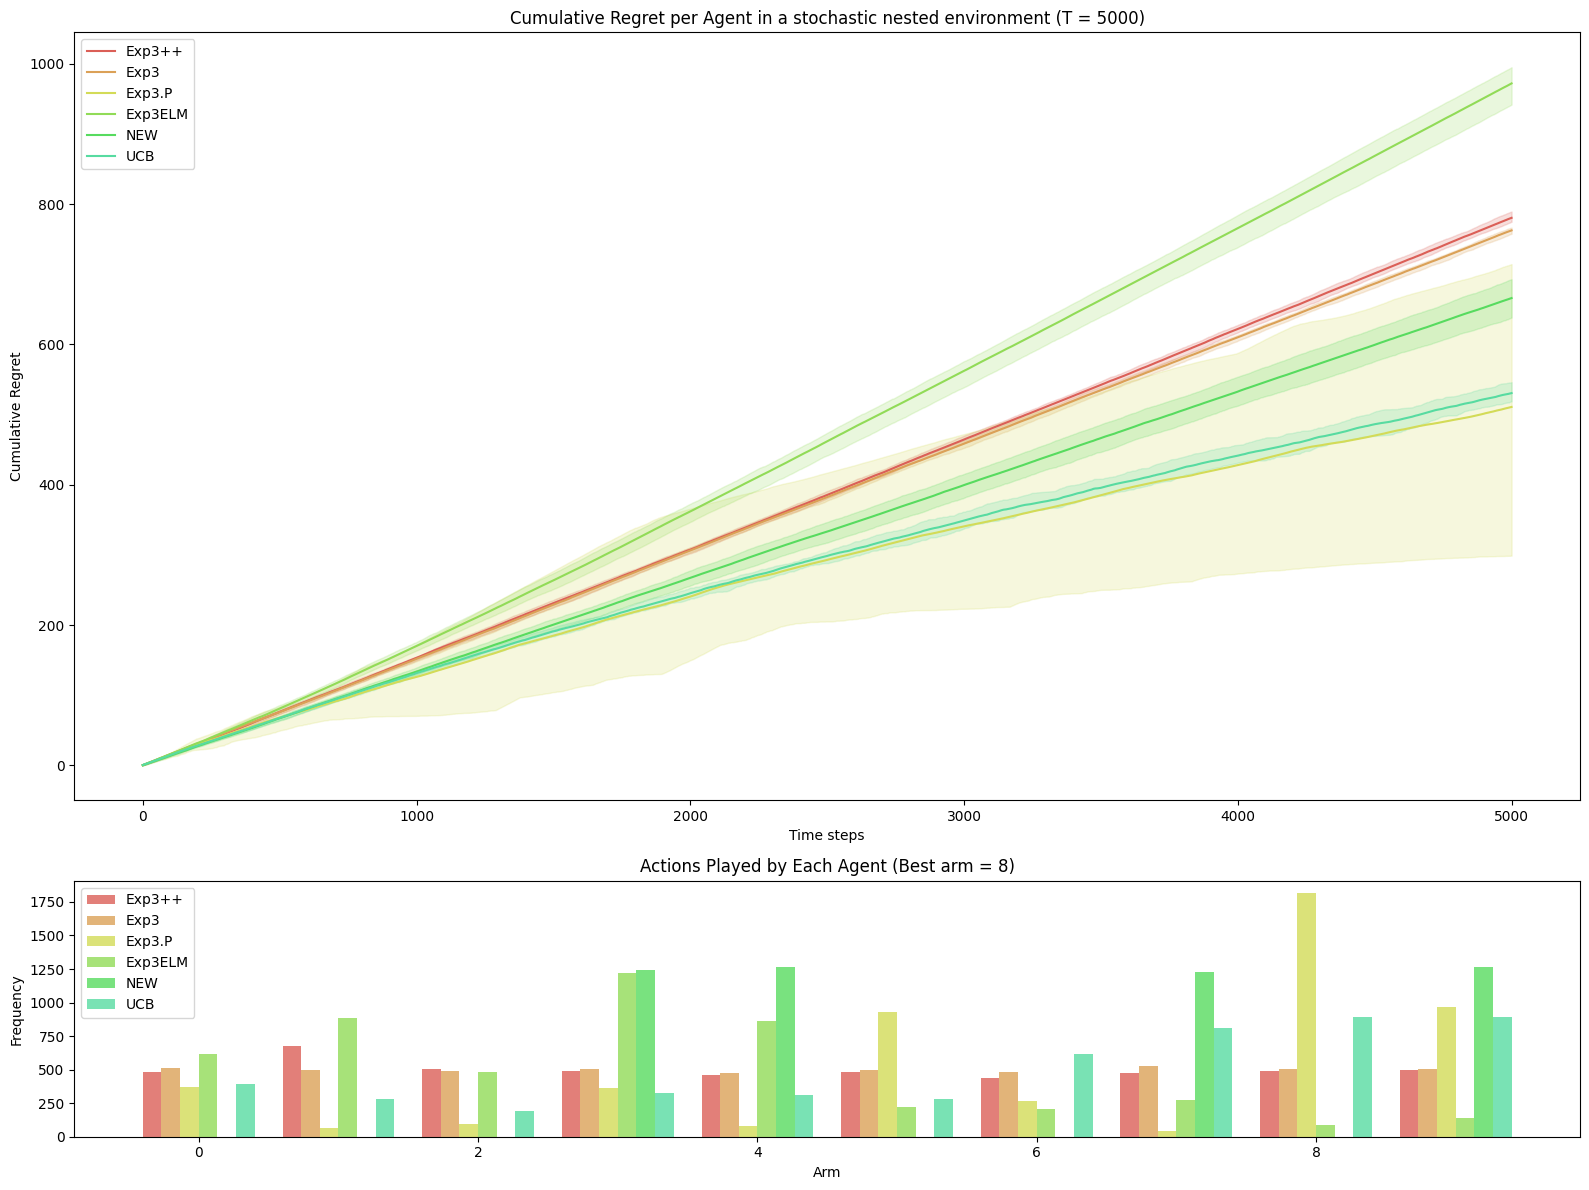

In [ ]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
exp3pp = Exp3PP(tree, T)
exp3 = Exp3(tree, T)
exp3P = Exp3P(tree, T)
new = NestedExponentialWeights(tree, T)
exp3elm = Exp3ELM(tree, T)
ucb = UCB(tree, T)


regrets = experiment(environment=env, agents=[exp3pp, exp3, exp3P, exp3elm, new, ucb], Nmc=10, T=T)
plot_regret_and_histogram(regrets, agents=[exp3pp, exp3, exp3P, exp3elm, new, ucb], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)

In [26]:
import numpy as np

class NestedExp3:
    def __init__(self, tree, T, rng_seed=None):
        self.tree = tree
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.rng = np.random.default_rng(rng_seed)
        self.EPS = 1e-8
        self.T = T
        self.all_nodes = self.tree.get_all_nodes()
        self.nb_nodes = len(self.all_nodes)
        self.dic_name_i = {node.name:i for i,node in enumerate(self.all_nodes)}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.all_nodes)}
        self.reset()

    def reset(self):
        self.t = 0
        self.action_history = []
        self.rewards = []
        self.init_probas()

    def init_probas(self):
        self.p = np.zeros(self.nb_nodes)
        def recursive_init(n):
            if bool(n.children):
                childrens = n.children
                idxs = [self.dic_name_i[no.name] for no in childrens]
                for j, i in enumerate(idxs):
                    self.p[i] = 1 / len(childrens)
                    recursive_init(childrens[j])
            else:
                return
        recursive_init(self.tree.root)


    def draw_action(self, tree_step):
        self.t += 1
        tree = tree_step 
        node = tree_step.root
        index = []
        node_path = []
        proba_path = []
        reward_path = []
        while bool(node.children):
            self.lr = 1 / np.sqrt(self.t + 1)
            childrens = node.children
            idxs = [self.dic_name_i[n.name] for n in childrens]
            probas = self.p[idxs]
            idx_node = self.rng.choice(range(len(childrens)), p=probas)
            chosen_children = childrens[idx_node]
            index.append(self.dic_name_i[chosen_children.name])
            node_path.append(idx_node)
            proba_path.append(probas[idx_node])
            intermediate_reward = chosen_children.value
            reward_path.append(intermediate_reward)
            node = chosen_children

        self.reward_path = reward_path
        self.indexes = index
        self.proba_path = proba_path
        #self.update(tree_step, index, node_path, proba_path, reward_path)
        idx_leaf = self.dico_leaf_i[node.name]
        self.action_history.append(idx_leaf)
        return idx_leaf


    def observe_reward(self, r):
        self.rewards.append(r)
        self.update()

    def update(self):
        indexes = self.indexes[::-1]
        reward_path = self.reward_path[::-1]
        proba_path = self.proba_path
        L = len(indexes)
        for i in range(L):
            unbiased_estimator = np.sum(reward_path[i:]) / np.prod(proba_path[i:])
            self.p[indexes[i]] *= np.exp(-self.lr*unbiased_estimator)
            # Update pour avoir des probas 
            current_node = self.all_nodes[indexes[i]]
            parent = current_node.parent
            siblings = parent.children 
            indexes_siblings = [self.dic_name_i[n.name] for n in siblings]
            sub_probas = self.p[indexes_siblings]
            for i in indexes_siblings:
                self.p[i] /= np.sum(sub_probas)

    def name(self):
        return "NestedExp3"
    
    def nested(self):
        return True

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


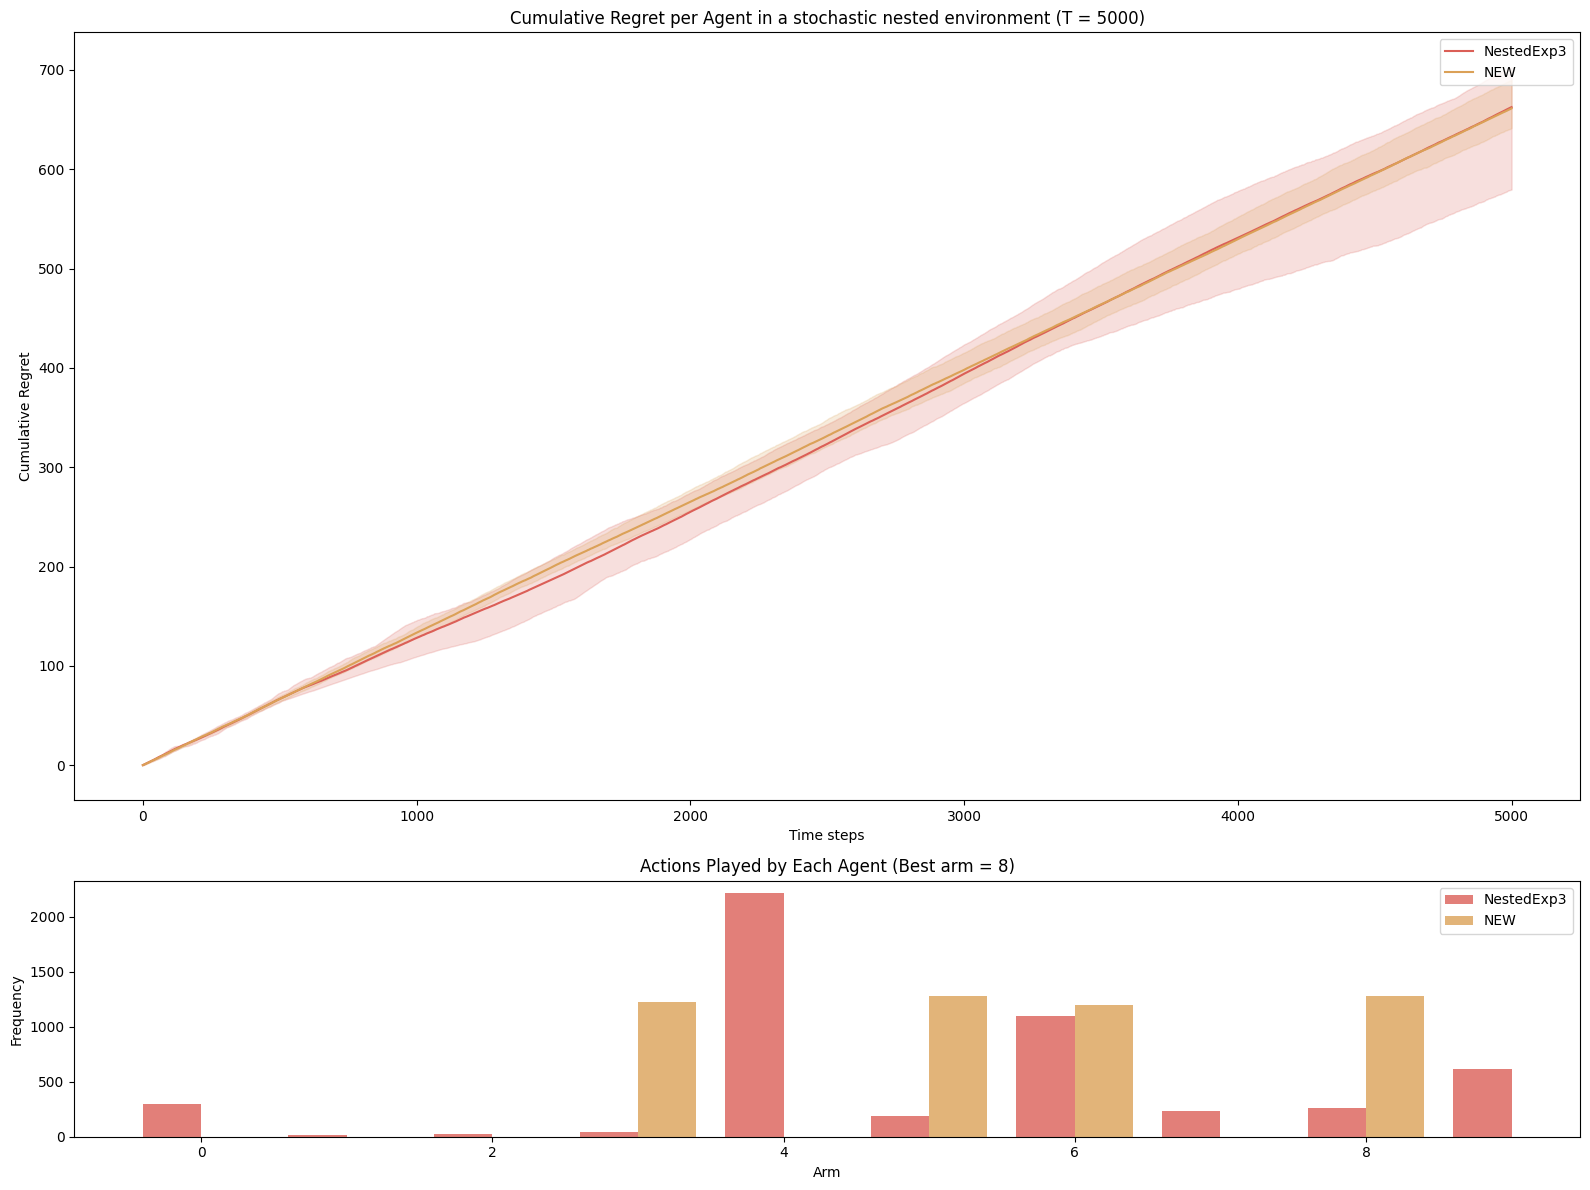

In [28]:
T = 5_000
K = 10

env = NestedBanditEnv()
tree = env.tree
new = NestedExponentialWeights(tree, T)
nexp3 = NestedExp3(tree, T)


regrets = experiment(environment=env, agents=[nexp3, new], Nmc=10, T=T)
plot_regret_and_histogram(regrets, agents=[nexp3, new], env=env, logscale=False, lb=None, q=10, save_pdf=None, horizon=T)